# Chinook record store signings

This notebook represents my work on a guided project, as provided by Dataquest.io.

The Chinook record store has just signed a deal with a new record label and we are tasked with selecting the first three albums that will be added to the store from a list of four.

All four albums are from artists that do not have any tracks in the store at present.

Artist Name | Genre
--- | ---
Regal | Hip_hop
Red Tone | Punk
Meteor and the Girls | Pop
Slim Jim Bites | Blues

The record label specializes in U.S. artists. Our first task is to find out which genres sell the best in the USA.

Here is a screenshot of the 'Chinook' database that we will be leveraging for our sample data.
![](chinook.PNG)

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [3]:
def run_command(q):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(q)

In [4]:
def show_tables():
    q = """
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table", "view")
    """
    return run_query(q)

In [5]:
db_tables = show_tables()
print(db_tables)

                       name   type
0                     album  table
1                    artist  table
2                  customer  table
3                  employee  table
4                     genre  table
5                   invoice  table
6              invoice_line  table
7                media_type  table
8                  playlist  table
9            playlist_track  table
10                    track  table
11             country_view   view
12  album_id_per_invoice_id   view


          tracks_sold  tracks_sold_per
name                                  
Metal            1436        54.332198
R&B/Soul          376        14.226258
Blues             329        12.447976


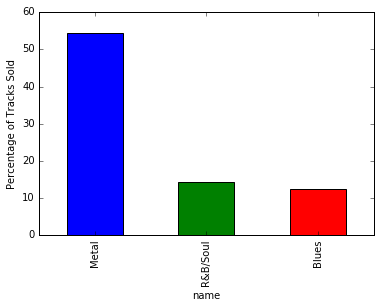

In [6]:
q = """
WITH genres_usa AS (
    SELECT
        g.name,
        SUM(il.quantity) tracks_sold
    FROM genre g
    INNER JOIN track t ON t.genre_id = g.genre_id
    INNER JOIN playlist_track pt ON t.track_id = pt.track_id
    INNER JOIN invoice_line il on pt.track_id = il.track_id
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    GROUP BY g.name
    HAVING i.billing_country = "USA"
    ORDER BY COUNT(il.quantity) DESC
),
    track_total AS (
    SELECT
        SUM(tracks_sold) AS tracks_sold_sum
    FROM genres_usa
)

SELECT
    g.name,
    g.tracks_sold,
    (CAST(g.tracks_sold AS Float) / t.tracks_sold_sum) * 100 tracks_sold_per
FROM genres_usa g, track_total t
LIMIT 3;
"""

result = run_query(q)

result.set_index("name", drop=True, inplace=True)
print(result)

ax = result.iloc[:,1].plot.bar()
ax.set_ylabel('Percentage of Tracks Sold')
plt.show()

## Genre Analysis
Based on our analysis, Metal, R&B/Soul, and Blues are the most popular genres (out of eight) sold in the U.S.A. In fact, these three genres account for 80% of sales.

Our current slate of artists miss the mark in terms of genre for the most part. The exception is **Slim Jim Bites**, whose genre is the Blues. We may want to pour additional advertisement money into that one particular album to cater to the popularity of Blues albums.

## Agent Analysis
Next we have been asked to analyze the purchases of customers belonging to each employee to see which *sales support agent* is performing better or worse than the others.

                             title    total
emp_name                                   
Jane Peacock   Sales Support Agent  1731.51
Margaret Park  Sales Support Agent  1584.00
Steve Johnson  Sales Support Agent  1393.92


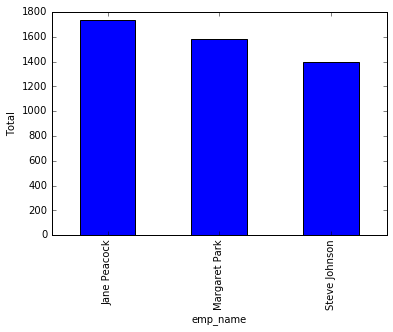

In [7]:
q = """
    SELECT
        e.first_name || " " || e.last_name emp_name,
        e.title,
        SUM(i.total) total
    FROM employee e
    INNER JOIN customer c ON c.support_rep_id = e.employee_id
    INNER JOIN invoice i on i.customer_id = c.customer_id
    WHERE e.title = 'Sales Support Agent'
    GROUP BY emp_name
"""

result = run_query(q)

result.set_index("emp_name", drop=True, inplace=True)

print(result)
ax = result.plot.bar()
ax.set_ylabel('Total')
ax.get_legend().remove()

Overall we find that Jane Peacock manages the highest dollar total, at $1,731. For comparison, Jane manages roughly 24% more in sales than Steve Johnson.

This does not necessarily mean that Jane is a more apt sales support rep than Steve. Rather, she may manage more popular artists. Given her high dollar figure, she may handle a higher workload as a sales support agent.

## Analyze Customer by Country
We have been given guidance to use the country value from the *customers* table. In particular, we have been directed to calculate data for each country on the:
* total number of customers
* total value of sales
* average value of sales per customer
* average order value

Countries with only one customer will be grouped into an 'Other' category for analysis purposes.

In [8]:
v = '''
CREATE VIEW country_view AS
SELECT
        CASE
        WHEN c2.counter = 1 THEN 'Other'
        ELSE c.country
    END AS country,
    c.customer_id,
    i.invoice_id,
    i.total
FROM customer c
INNER JOIN invoice i ON c.customer_id = i.customer_id
INNER JOIN (SELECT country, count(*) counter FROM customer GROUP BY country) c2 on c2.country = c.country
;
'''
run_command('DROP VIEW IF EXISTS country_view')
run_command(v)

q = '''
SELECT
    country,
    COUNT(DISTINCT(customer_id)) AS num_cust,
    SUM(total) total_sales,
    SUM(total) / COUNT(DISTINCT(customer_id)) AS avg_sales_per_customer,
    SUM(total) / COUNT(DISTINCT(invoice_id)) AS avg_order_value
FROM 
    (
    SELECT 
        cv.*,
        CASE
            WHEN cv.country = 'Other' THEN 1
            ELSE 0
        END AS sort
    FROM country_view cv
    )
GROUP BY country
ORDER BY sort, SUM(total) DESC
'''

run_query(q)

,country,num_cust,total_sales,avg_sales_per_customer,avg_order_value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


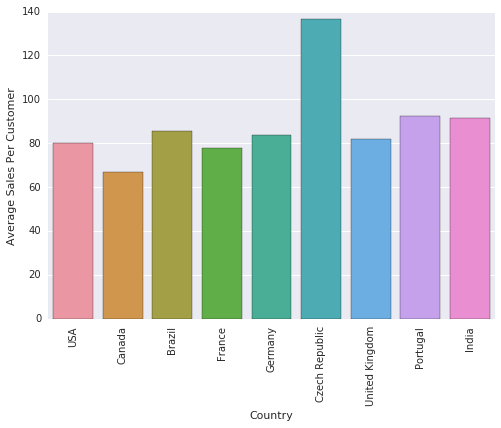

In [9]:
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

country_metrics = run_query(q)[:-1]

bp = sns.barplot('country', 'avg_sales_per_customer', data=country_metrics)
plt.xticks(rotation=90)
bp.set_ylabel('Average Sales Per Customer')
bp.set_xlabel('Country')
plt.show()

As we can see, average sales per customer is much higher in the Czech Republic. This data is skewed in that the Czech Republic only has two customers listed.

More interesting is a comparison of our top two countries by number of customers - the United States and Canada. Average sales per customer is approximately 13 lower in Canada. This suggests that consumer demands lags behind in Canada or potentially that we have a market that could be more fully leveraged.

Let us now compare the spread of total sales across the various major countries in terms of percentages.

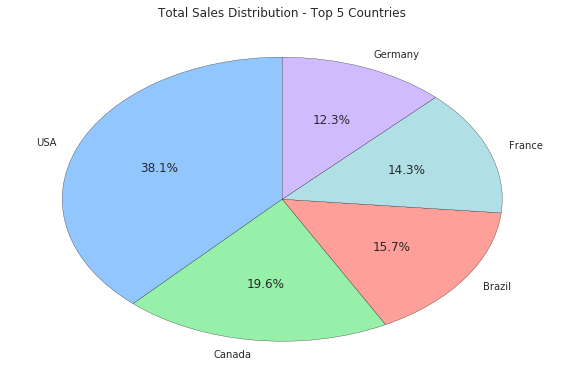

In [14]:
country_metrics_top = country_metrics[:5]
fig1, ax1 = plt.subplots()
labels = country_metrics_top['country']
sizes = country_metrics_top['total_sales']
ax1.pie(sizes, labels=labels, startangle=90, autopct='%1.1f%%')
ax1.set_title('Total Sales Distribution - Top 5 Countries')
plt.tight_layout()
plt.show()

For the top 5 countries in terms of total sales, we see that the total sales of the United States is at least double of the next country. 

On that note, let's check out the percentage of customers in those top 5 countries.

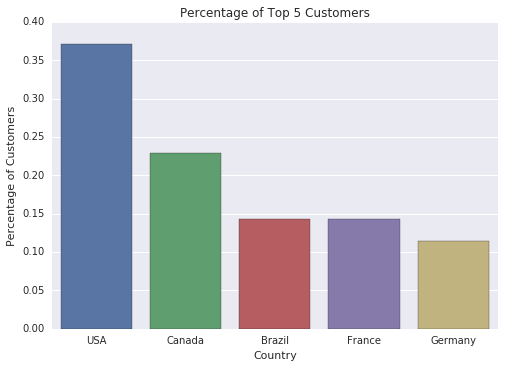

In [11]:
total_cust = country_metrics_top['num_cust'].sum()
total_cust_percent = country_metrics_top['num_cust'] / total_cust

sns.set_color_codes("pastel")
ax = sns.barplot(x=country_metrics_top['country'], y=total_cust_percent)

ax.set_ylabel('Percentage of Customers')
ax.set_xlabel('Country')
ax.set_title('Percentage of Top 5 Customers')


The results are not surprising.  The larger markets in terms of total sales (such as the United States) tend to have a greater number of customers.  Again, we see a potential opportunity in Canada, given its higher percentage of customers (23%) to its percentage of total sales (19.6%) within the top five countries.

Finally, let us examine the distribution of average order values using a box and whisker chart.

7.942671755725189


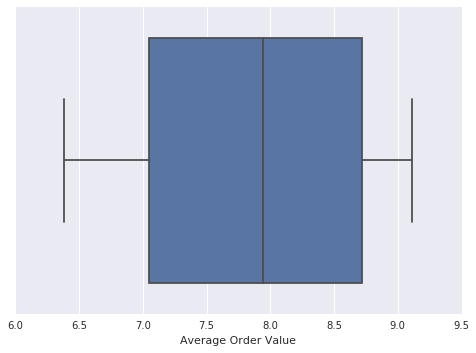

In [12]:
median_aov = country_metrics['avg_order_value'].median()
print(median_aov)

ax = sns.boxplot(country_metrics['avg_order_value'])
ax.set_xlabel('Average Order Value')

Viewing the boxplot we can see that average order value is fairly well-centered at 8.94, with no obvious outliers. Further research should be conducted to determine why certain countries obtained a relatively higher 'average order value'. For example, is there a correlation between 'average order value' and the relative wealth of a country?

Overall, my recommendation for the marketing team would be to target the United States and Canada. Again, we are trying to market three new albums from artists that do not currently have any tracks in the stores right now. We should avoid markets in which we only have a weak sales presence to date.

Combined, the United States and Canada represent 58% of total sales in our top five countries. We have thus already achieved a level of sales saturation and marekting presence in these two countries. In particular we may want to focus on increasing the average sales per customer in Canada.

## Analysis of Individual Tracks to Albums
Management is considering changing their purchasing strategy to save money. They are considering whether to purchase only the most popular tracks from each album from the record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks versus whole albums, so that management can understand the effect that their decision may have on overall revenues.

There are two edge cases that we will need to account for:
* Albums that only have one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
* Customers may decide to manually add every track from an album and then add a few other individual tracks.

Since we are concerned with maximizing revenue we can safely ignore albums consisting of only a few tracks. Management has informed us to ignore the second scenario, since it is relatively unusual.

We will need to determine whether each invoice has all the tracks from an album.
We will write a query that categorizes each invoice as either an album purchase or not.

In [13]:
v = '''
CREATE VIEW album_id_per_invoice_id AS
SELECT
    i.invoice_id,
    il.track_id,
    t.album_id
FROM invoice i
INNER JOIN invoice_line il ON i.invoice_id = il.invoice_id
INNER JOIN track t ON il.track_id = t.track_id
GROUP BY i.invoice_id;
'''
run_command('DROP VIEW IF EXISTS album_id_per_invoice_id')
run_command(v)

q = '''
SELECT
    SUM(album_purchase) num_full_album_purchases,
    COUNT(DISTINCT(invoice_id)) num_invoices,
    CAST(SUM(album_purchase) AS FLOAT) / COUNT(DISTINCT(invoice_id)) AS percent_album_purchases

FROM (SELECT
    a.invoice_id,
    a.album_id,
    CASE
       WHEN
           (
           SELECT il.track_id
           FROM invoice i
           INNER JOIN invoice_line il ON i.invoice_id = il.invoice_id
           WHERE i.invoice_id = a.invoice_id
           
           EXCEPT
           
           SELECT tr.track_id
           FROM album al
           INNER JOIN track tr ON tr.album_id = al.album_id
           WHERE al.album_id = a.album_id
           ) IS NULL
           
           AND
           
           (
           SELECT tr.track_id
           FROM album al
           INNER JOIN track tr ON tr.album_id = al.album_id
           WHERE al.album_id = a.album_id
           
           EXCEPT
           
           SELECT il.track_id
           FROM invoice i
           INNER JOIN invoice_line il ON i.invoice_id = il.invoice_id
           WHERE i.invoice_id = a.invoice_id
           
           ) IS NULL
       THEN 1
    ELSE 0
    END AS album_purchase
FROM album_id_per_invoice_id a);
'''

run_query(q)

,num_full_album_purchases,num_invoices,percent_album_purchases
0,114,614,0.185668


The findings are clear. 19% of invoices constitute full album purchases. As such, Chinook should continue to purchase whole albums. The alternative may jeopardize 19% of sales. 